Based on:  
https://www.tensorflow.org/datasets/keras_example  
https://www.tensorflow.org/tutorials/images/data_augmentation  


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from frouros.detectors.data_drift import MMD

# MNIST input pipeline

In [3]:
# Load the MNIST dataset
(ds_train, ds_test) , metadata= tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)




INFO:absl:Load dataset info from /home/se1131/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.


INFO:absl:Reusing dataset mnist (/home/se1131/tensorflow_datasets/mnist/3.0.1)
2023-07-20 16:51:57.288176: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
INFO:absl:Constructing tf.data.Dataset mnist for split ['train', 'test'], from /home/se1131/tensorflow_datasets/mnist/3.0.1


In [4]:


def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(metadata.splits['train'].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


# Define a function to duplicate the input data (x, x)

def preprocess_data(image, label):
    return (image, image)

ds_train = ds_train.map(preprocess_data)
 

In [5]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_data)

# Create image encoder

In [6]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28)),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28,1))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim=64)


In [7]:
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsoluteError())


In [8]:

autoencoder.fit(ds_train, epochs=10, validation_data=ds_test)

Epoch 1/10


2023-07-20 16:52:14.245084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-07-20 16:52:14.246111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


1861/1875 [============================>.] - ETA: 0s - loss: 0.0941

2023-07-20 16:52:24.261167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-07-20 16:52:24.262202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


1875/1875 [==============================] - 11s 4ms/step - loss: 0.0940 - val_loss: 0.0755
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0696 - val_loss: 0.0665
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0647 - val_loss: 0.0634
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0628 - val_loss: 0.0624
Epoch 5/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0623 - val_loss: 0.0621
Epoch 6/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0618 - val_loss: 0.0615
Epoch 7/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0614 - val_loss: 0.0613
Epoch 8/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0612 - val_loss: 0.0609
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0609 - val_loss: 0.0608
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0608 - val_lo

# Create and train the model

In [21]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [22]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
model.fit(ds_train, epochs=6, validation_data=ds_test)

Epoch 1/6
469/469 [==============================] - 3s 3ms/step - loss: 0.3600 - sparse_categorical_accuracy: 0.9012 - val_loss: 0.1968 - val_sparse_categorical_accuracy: 0.9418
Epoch 2/6
469/469 [==============================] - 1s 3ms/step - loss: 0.1682 - sparse_categorical_accuracy: 0.9521 - val_loss: 0.1393 - val_sparse_categorical_accuracy: 0.9595
Epoch 3/6
469/469 [==============================] - 1s 3ms/step - loss: 0.1214 - sparse_categorical_accuracy: 0.9650 - val_loss: 0.1114 - val_sparse_categorical_accuracy: 0.9678
Epoch 4/6
469/469 [==============================] - 2s 3ms/step - loss: 0.0950 - sparse_categorical_accuracy: 0.9724 - val_loss: 0.1015 - val_sparse_categorical_accuracy: 0.9706
Epoch 5/6
469/469 [==============================] - 1s 3ms/step - loss: 0.0764 - sparse_categorical_accuracy: 0.9782 - val_loss: 0.0875 - val_sparse_categorical_accuracy: 0.9735
Epoch 6/6
469/469 [==============================] - 1s 3ms/step - loss: 0.0630 - sparse_categorical_accu

# Data augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.3),
])

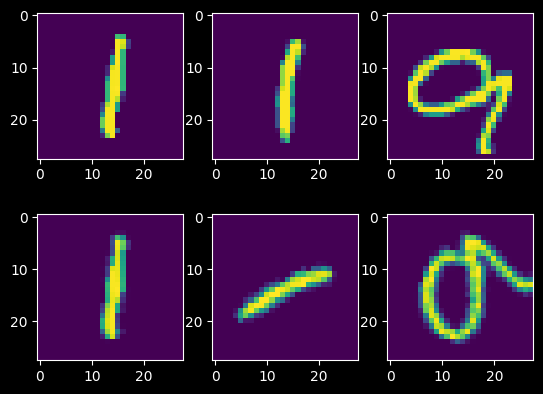

In [14]:
images, labels = next(iter(ds_train))
images = images.numpy()
labels = labels.numpy()
augmented_images = data_augmentation(images).numpy()
fig, ax = plt.subplots(nrows=2, ncols=3)

for i in range(ax.shape[1]):
    ax[0,i].imshow(images[i])
    ax[1,i].imshow(augmented_images[i])


# Data drift detection 

A significance level of $\alpha = 0.05$ is set to perform the hypothesis test.


In [9]:
alpha = 0.05

Maximum Mean Discrepancy (MMD) {cite:p}`JMLR:v13:gretton12a` imported from Frouros is used with a Radial Basis Function kernel (RBF), set by default in MMD. In addition to calculating the corresponding MMD statistic, p-value is estimated using permutation test.

In [15]:
from frouros.callbacks import PermutationTestDistanceBased
detector = MMD(
    callbacks=[
        PermutationTestDistanceBased(
            num_permutations=1000,
            random_state=43,
            num_jobs=-1,
            name="permutation_test",
            verbose=False,
        ),
    ],
)
_ = detector.fit(X=augmented_images.reshape(images.shape[0], -1))

Compare each test dataset to the dataset fitted by MMD.


In [18]:
mmd, callbacks_logs =  detector.compare(X=augmented_images.reshape(images.shape[0], -1))

p_value  = callbacks_logs["permutation_test"]["p_value"]
print(round(p_value, 4))

-0.0003563507539910905

In [17]:
drift = p_value< alpha
drift

False

In [78]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the MNIST dataset
metadata, ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Extract the train and test datasets
ds_train, ds_test = metadata

# Define a function to duplicate the input data (x, x)
def preprocess_data(image, label):
    return (image, image)

# Apply the preprocessing function to both train and test datasets
ds_train = ds_train.map(preprocess_data)
ds_test = ds_test.map(preprocess_data)

# Normalize the images to [0, 1] range
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.float32) / 255.0))
ds_test = ds_test.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.float32) / 255.0))

# Shuffle and batch the datasets
ds_train = ds_train.shuffle(1024).batch(32)
ds_test = ds_test.batch(32)

# Create and compile the autoencoder model
autoencoder = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(28*28, activation='sigmoid'),
    tf.keras.layers.Reshape((28, 28))
])

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(ds_train, epochs=10, validation_data=ds_test)


INFO:absl:Load dataset info from /home/se1131/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/home/se1131/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split ['train', 'test'], from /home/se1131/tensorflow_datasets/mnist/3.0.1


Epoch 1/10


2023-07-20 15:44:14.972979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-07-20 15:44:14.974463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


1872/1875 [============================>.] - ETA: 0s - loss: 0.0231

2023-07-20 15:44:26.209724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-07-20 15:44:26.210914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


1875/1875 [==============================] - 12s 6ms/step - loss: 0.0231 - val_loss: 0.0116
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0099 - val_loss: 0.0082
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0079 - val_loss: 0.0070
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0068 - val_loss: 0.0062
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 9/10
 165/1875 [=>............................] - ETA: 8s - loss: 0.0051

KeyboardInterrupt: 